 # 🧠 02 - Treinamento de Modelos de Churn (LightGBM + Baseline)



 Script para rodar no VSCode (modo Jupyter com células `# %%`) usando:

 - data/base_modelagem.csv

 - data/features_modelagem.json



 Etapas:

 1. Carregar base e separar X / y

 2. Split train/test estratificado

 3. Treinar baseline (Regressão Logística)

 4. Treinar modelo principal (LightGBM com categorias nativas)

 5. Avaliar e comparar modelos

 6. Salvar métricas, gráficos e modelo final

In [1]:
from pathlib import Path
import json
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    RocCurveDisplay,
    classification_report,
)
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

import joblib

from lightgbm import LGBMClassifier

warnings.filterwarnings("ignore")

plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 1200)

TARGET_COL = "Attrition"

print("✅ Imports concluídos para treinamento.")



✅ Imports concluídos para treinamento.


 ## 1. Funções utilitárias

In [2]:
def get_project_root() -> Path:
    """
    Detecta a pasta raiz do projeto.
    Se estiver rodando dentro de `notebooks/`, sobe um nível.
    """
    root = Path.cwd()
    if root.name.lower() in {"notebooks", "nb"}:
        root = root.parent
    return root


def load_data(project_root: Path):
    """
    Carrega a base de modelagem e o arquivo de features.
    Retorna X, y, lista de numéricas e categóricas.
    """
    data_path = project_root / "data" / "base_modelagem.csv"
    features_path = project_root / "data" / "features_modelagem.json"

    if not data_path.exists():
        raise FileNotFoundError(
            f"Arquivo base_modelagem.csv não encontrado em {data_path}"
        )

    if not features_path.exists():
        raise FileNotFoundError(
            f"Arquivo features_modelagem.json não encontrado em {features_path}"
        )

    df = pd.read_csv(data_path)
    print(
        f"📄 Base de modelagem carregada: {df.shape[0]} linhas, {df.shape[1]} colunas"
    )

    with open(features_path, "r", encoding="utf-8") as f:
        feats_cfg = json.load(f)

    num_features = feats_cfg.get("numeric_features", [])
    cat_features = feats_cfg.get("categorical_features", [])
    target = feats_cfg.get("target", TARGET_COL)

    # Garantir que colunas existem
    missing_cols = set(num_features + cat_features + [target]) - set(df.columns)
    if missing_cols:
        raise ValueError(
            f"As seguintes colunas definidas em features_modelagem.json não existem na base: {missing_cols}"
        )

    # Separar X, y
    X = df[num_features + cat_features].copy()
    y = df[target].astype(int).copy()

    # Ajustar tipos categóricos
    for c in cat_features:
        X[c] = X[c].astype("category")

    print("🔢 Features numéricas:", num_features)
    print("🔠 Features categóricas:", cat_features)
    print(f"🎯 Target: {target}")
    print("✅ Dados preparados.")

    return X, y, num_features, cat_features, target


def compute_metrics(y_true, y_pred, y_proba):
    """
    Calcula métricas principais para classificação binária.
    """
    acc = accuracy_score(y_true, y_pred)
    roc = roc_auc_score(y_true, y_proba)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="binary", pos_label=1
    )

    return {
        "accuracy": acc,
        "roc_auc": roc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }


def plot_confusion(y_true, y_pred, title: str, save_path: Path | None = None):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(title)
    plt.xlabel("Predito")
    plt.ylabel("Real")
    plt.tight_layout()

    if save_path is not None:
        save_path.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(save_path, dpi=120)
        print(f"🖼️ Matriz de confusão salva em: {save_path}")
    plt.show()


def plot_roc(y_true, y_proba, title: str, save_path: Path | None = None):
    plt.figure(figsize=(6, 5))
    RocCurveDisplay.from_predictions(y_true, y_proba)
    plt.title(title)
    plt.tight_layout()
    if save_path is not None:
        save_path.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(save_path, dpi=120)
        print(f"🖼️ Curva ROC salva em: {save_path}")
    plt.show()



 ## 2. Treinamento dos modelos

In [ ]:
def train_logistic_baseline(
    X_train, X_test, y_train, y_test, numeric_features, categorical_features
):
    """
    Baseline com Regressão Logística + One-Hot nas categorias.
    Útil como referência de performance.
    """
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", "passthrough", numeric_features),
            ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ]
    )

    log_reg = LogisticRegression(
        max_iter=500,
        class_weight="balanced",
        n_jobs=-1,
    )

    clf = Pipeline(
        steps=[
            ("preprocess", preprocessor),
            ("model", log_reg),
        ]
    )

    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)[:, 1]

    metrics = compute_metrics(y_test, y_pred, y_proba)

    print("\n📊 Métricas - Baseline Regressão Logística:")
    for k, v in metrics.items():
        print(f"  - {k}: {v:.4f}")

    print("\nRelatório de classificação (Logistic):")
    print(classification_report(y_test, y_pred, digits=4))

    return clf, metrics, y_pred, y_proba


def train_lgbm_model(
    X_train, X_test, y_train, y_test, categorical_features
):
    """
    Modelo principal: LightGBM com tratamento nativo para variáveis categóricas.
    Compatível com versões que não aceitam 'verbose' no .fit().
    """
    # Garantir que as colunas categóricas são do tipo 'category'
    X_train_lgb = X_train.copy()
    X_test_lgb = X_test.copy()
    for c in categorical_features:
        X_train_lgb[c] = X_train_lgb[c].astype("category")
        X_test_lgb[c] = X_test_lgb[c].astype("category")

    # verbose controlado no construtor (não no fit)
    model = LGBMClassifier(
        objective="binary",
        random_state=42,
        class_weight="balanced",
        n_estimators=500,
        learning_rate=0.05,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        n_jobs=-1,
        verbose=-1,  # silencia logs
    )

    # fit sem o argumento 'verbose'
    model.fit(
        X_train_lgb,
        y_train,
        categorical_feature=categorical_features,
        eval_set=[(X_test_lgb, y_test)],  # opcional, apenas para monitorar
        eval_metric="auc",
    )

    y_pred = model.predict(X_test_lgb)
    y_proba = model.predict_proba(X_test_lgb)[:, 1]

    metrics = compute_metrics(y_test, y_pred, y_proba)

    print("\n📊 Métricas - LightGBM:")
    for k, v in metrics.items():
        print(f"  - {k}: {v:.4f}")

    print("\nRelatório de classificação (LightGBM):")
    print(classification_report(y_test, y_pred, digits=4))

    return model, metrics, y_pred, y_proba



def plot_lgbm_feature_importance(
    model, feature_names, top_n=20, save_path: Path | None = None
):
    """
    Plota a importância das features do modelo LightGBM.
    """
    importances = model.feature_importances_
    fi = pd.DataFrame({"feature": feature_names, "importance": importances})
    fi = fi.sort_values("importance", ascending=False).head(top_n)

    plt.figure(figsize=(8, 6))
    sns.barplot(data=fi, x="importance", y="feature")
    plt.title(f"Top {top_n} - Importância das Features (LightGBM)")
    plt.tight_layout()

    if save_path is not None:
        save_path.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(save_path, dpi=120)
        print(f"🖼️ Importância de features salva em: {save_path}")
    plt.show()



 ## 3. Pipeline principal de execução

In [4]:
def main():
    project_root = get_project_root()
    print(f"📁 Projeto: {project_root}")

    reports_dir = project_root / "reports"
    figures_dir = reports_dir / "figures"
    models_dir = project_root / "models"

    reports_dir.mkdir(exist_ok=True, parents=True)
    figures_dir.mkdir(exist_ok=True, parents=True)
    models_dir.mkdir(exist_ok=True, parents=True)

    # 1) Carrega dados
    X, y, num_features, cat_features, target = load_data(project_root)

    # 2) Split train/test estratificado
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.2,
        random_state=42,
        stratify=y,
    )

    print(f"\n🔀 Split realizado:")
    print(f"  - Treino: {X_train.shape[0]} registros")
    print(f"  - Teste : {X_test.shape[0]} registros")

    # 3) Baseline Logistic Regression
    log_model, log_metrics, y_pred_log, y_proba_log = train_logistic_baseline(
        X_train, X_test, y_train, y_test, num_features, cat_features
    )

    plot_confusion(
        y_test,
        y_pred_log,
        title="Matriz de Confusão - Logistic Regression",
        save_path=figures_dir / "matriz_confusao_logistic.png",
    )
    plot_roc(
        y_test,
        y_proba_log,
        title="Curva ROC - Logistic Regression",
        save_path=figures_dir / "roc_curve_logistic.png",
    )

    # 4) Modelo principal LightGBM
    lgbm_model, lgbm_metrics, y_pred_lgbm, y_proba_lgbm = train_lgbm_model(
        X_train, X_test, y_train, y_test, cat_features
    )

    plot_confusion(
        y_test,
        y_pred_lgbm,
        title="Matriz de Confusão - LightGBM",
        save_path=figures_dir / "matriz_confusao_lightgbm.png",
    )
    plot_roc(
        y_test,
        y_proba_lgbm,
        title="Curva ROC - LightGBM",
        save_path=figures_dir / "roc_curve_lightgbm.png",
    )

    # Importância de features do LightGBM
    feature_names = num_features + cat_features
    plot_lgbm_feature_importance(
        lgbm_model,
        feature_names=feature_names,
        top_n=20,
        save_path=figures_dir / "feature_importance_lightgbm.png",
    )

    # 5) Comparar métricas e salvar CSV
    metrics_df = pd.DataFrame.from_dict(
        {
            "logistic_regression": log_metrics,
            "lightgbm": lgbm_metrics,
        },
        orient="index",
    )
    metrics_path = reports_dir / "metrics_modelos.csv"
    metrics_df.to_csv(metrics_path)
    print(f"\n📊 Métricas salvas em: {metrics_path}")
    print(metrics_df)

    # 6) Escolher melhor modelo (por ROC-AUC) e salvar
    best_model_name = metrics_df["roc_auc"].idxmax()
    if best_model_name == "lightgbm":
        best_model = lgbm_model
    else:
        best_model = log_model

    model_path = models_dir / "model_final.pkl"
    joblib.dump(best_model, model_path)
    print(f"\n💾 Modelo final salvo em: {model_path}")
    print(f"🏆 Melhor modelo: {best_model_name}")



📁 Projeto: c:\Users\Iago\OneDrive\Desktop\Projeto Churn\Bank-Churn-Prediction-montes_claros
📄 Base de modelagem carregada: 10127 linhas, 23 colunas
🔢 Features numéricas: ['Customer_Age', 'Dependent_count', 'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio', 'Ticket_Medio', 'Transacoes_por_Mes', 'Gasto_Medio_Mensal']
🔠 Features categóricas: ['Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category', 'Faixa_Idade', 'Renda_Class', 'Cluster']
🎯 Target: Attrition
✅ Dados preparados.

🔀 Split realizado:
  - Treino: 8101 registros
  - Teste : 2026 registros

📊 Métricas - Baseline Regressão Logística:
  - accuracy: 0.8534
  - roc_auc: 0.9196
  - precision: 0.5279
  - recall: 0.8154
  - f1: 0.6409

Relatório de classificação (Logistic):
              precision    recall  f1-score   support

           0     0.9606    0.

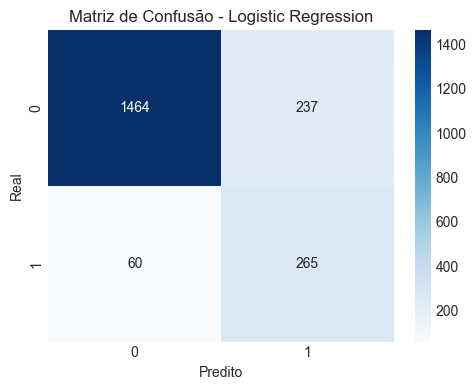

🖼️ Curva ROC salva em: c:\Users\Iago\OneDrive\Desktop\Projeto Churn\Bank-Churn-Prediction-montes_claros\reports\figures\roc_curve_logistic.png


<Figure size 600x500 with 0 Axes>

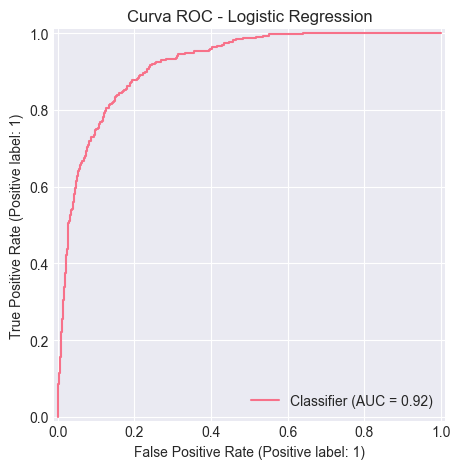

TypeError: LGBMClassifier.fit() got an unexpected keyword argument 'verbose'

In [5]:
if __name__ == "__main__":
    main()
